# What drives the price of a car?

## Business Understanding

We want to understand the factors that influence the sale price of a used car. This analysis will be used to come up with clear actionables for car dealerships.

We have access to a dataset of 426k used cars sold. In this project, we will develop and evaluate a few machine learning models based on this data.

## Data Understanding

In this section, we get familiar with the dataset that we have. After importing all the required python packages, we try to build an understanding of what the available dataset looks like:
* How many rows and columns?
* What are the data types of the columns, and how many missing values.
* Do the columns contain categorical or numerical data? Can categorical data be converted to discrete numerical data?
* How do the different features impact the sale price?

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats.mstats import winsorize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

import statsmodels.api as sm

In [2]:
#Read Data and view top few rows
data = pd.read_csv("data/vehicles.csv")
data.dropna().head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


In [3]:
# check the data types of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
# check the number of NA in each column
data.isna().sum()/data.shape[0]

id              0.000000
region          0.000000
price           0.000000
year            0.002823
manufacturer    0.041337
model           0.012362
condition       0.407852
cylinders       0.416225
fuel            0.007058
odometer        0.010307
title_status    0.019308
transmission    0.005988
VIN             0.377254
drive           0.305863
size            0.717675
type            0.217527
paint_color     0.305011
state           0.000000
dtype: float64

### Price (Target Variable)

We look at the distribution of the target variable (price in this case) to see if we need to filter data and/or transform any values.

The minimum price is 0, and the maximum price is \\$3Bn. Both these values seem in appropriate, and can be filtered out. We are going to drop any observations with a price under \\$1000 (we have a lot of \\$999 price entries), and over \\$500k.

Based on the histograms of the target variable below, <u>we will use the log price as the final target variable in this project.</u>

In [5]:
print(data.price.describe())
data = data.query('(price > 1000) and (price < 5e5)') # filter extreme values of price

count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64


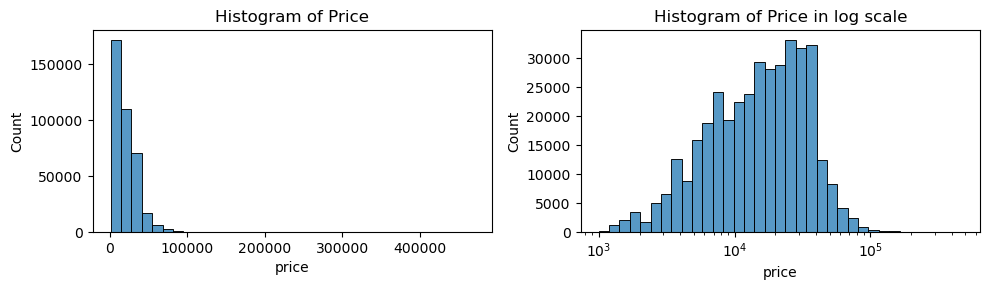

In [6]:
# view histograms for price and log price
fig, axs = plt.subplots(figsize=(10, 3), ncols= 2)

sns.histplot(data= data, x= "price", ax= axs[0], bins= 35)
axs[0].set_title("Histogram of Price")

axs[1].set(xscale="log")
sns.histplot(data= data, x= "price", ax= axs[1], bins= 35)
axs[1].set_title("Histogram of Price in log scale")

plt.tight_layout()

### Relationship of target variable with other features

#### Odometer (milage) and Year (of manufacture)

Based on an intuitive understanding of cars, price should have an inverse relationship with the odometer, which is supported by the data. Since there are some odometer entries that are 0, and some that are over 1 million miles, we choose to winsorize this column.
Furthermore, because of the scale of values in both price and odometer, we visualize both the variables in logarithmic scales. Even in log scale, the relationship appears to be non-linear.


We expect year of manufacture to be inversely related to the price. Intuitively, a car made in 1990 should cost less than one manufactured in 2020. Based on a simple scatterplot, this relationship seems to be true, but is not as strong as I had hoped.
I assume that after we control for other variables, this relationship would be stronger. 

Also, in the final modeling, we will use *'age'* as a feature instead of year. This would be for better interpretability.

<u>**NOTE**</u>: The code displayed here is to build charts using *seaborn* to reduce size of notebook. The displayed charts were built using plotly.

![title](images/px_year_odometer.png)

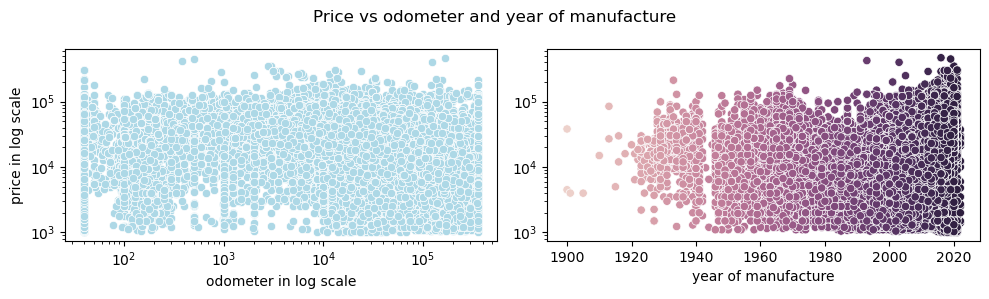

In [7]:
data['odometer'] = winsorize(data['odometer'], (0.01, 0.01)) # winsorize odometer readings

# Relationship between car size and price
fig, axs = plt.subplots(figsize= (10,3), ncols= 2)

sns.scatterplot(data= data, x="odometer", y= "price", color= "lightblue", ax= axs[0])
axs[0].set(yscale= "log", xscale= "log", ylabel= "price in log scale", xlabel= "odometer in log scale");


sns.scatterplot(data= data, x="year", y= "price", hue= "year", ax= axs[1])
axs[1].set(yscale= "log", xlabel= "year of manufacture", ylabel= "");
axs[1].get_legend().set_visible(False)

plt.suptitle("Price vs odometer and year of manufacture");
plt.tight_layout();


#### Size and Transmission

* In the left chart, it is easy to see that the full-size cars have a higher price, as compared to others.
* Automatic transmission results in a slightly higher price, as compared to manual transmission. But the *other* category has the highest price.

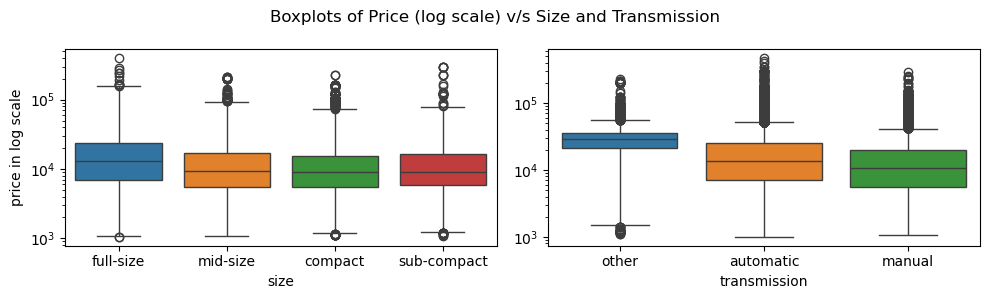

In [8]:
# Relationship between car size and price
fig, axs = plt.subplots(figsize=(10, 3), ncols= 2)
plt.suptitle("Boxplots of Price (log scale) v/s Size and Transmission")

axs[0].set(yscale= "log", ylabel= "price in log scale")
sns.boxplot(data = data, x= "size", y="price", hue= "size", ax= axs[0])
axs[0].get_legend().set_visible(False)

sns.boxplot(data = data, x= "transmission", y="price", hue= "transmission", ax= axs[1])
axs[1].set(yscale= "log", ylabel= "")
axs[1].get_legend().set_visible(False)

plt.tight_layout()

#### Condition, Fuel Type and Drive Type

* *New* cars seem to be worth more than cars in *fair* or *salvage* condition. Condition types seem to be ordered, with a more-or-less monotonic relationship with price. In the modeling section, we will use a LabelEncoder to convert this column to numeric.
* Both fuel type and drive type seem to impact the price of a used car. But there is no ordered relationship here. We will leave these columns as categorical variables.

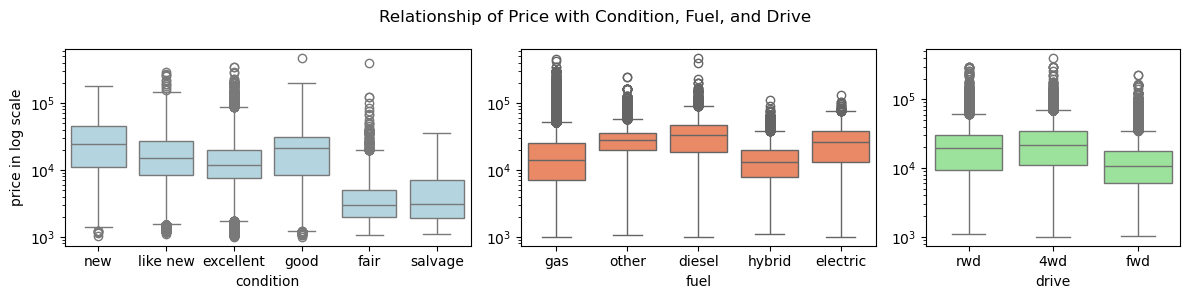

In [9]:
# Relationship between car size and price
fig, axs = plt.subplots(figsize=(12, 3), ncols= 3, width_ratios= [0.4, 0.35, 0.25])
plt.suptitle("Relationship of Price with Condition, Fuel, and Drive")

axs[0].set(yscale= "log", ylabel= "price in log scale")
sns.boxplot(data = data, x= "condition", y="price", color= "lightblue", ax= axs[0],
           order= ['new', 'like new','excellent','good','fair','salvage'])

sns.boxplot(data = data, x= "fuel", y="price", color= "coral", ax= axs[1])
axs[1].set(yscale= "log", ylabel= "")

sns.boxplot(data = data, x= "drive", y="price", color= "lightgreen", ax= axs[2])
axs[2].set(yscale= "log", ylabel= "")

plt.tight_layout()

#### No. of Cylinders
Higher number of cylinders seem to indicate a higher sale price for a used car.

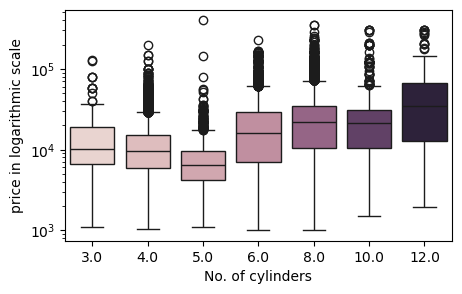

In [10]:
data['n_cylinder'] = pd.to_numeric(data['cylinders'].apply(lambda s: s.split(' ')[0] if isinstance(s,str) else ''), errors= 'coerce')

fig, axs = plt.subplots(figsize = (5,3))
sns.boxplot(data= data, x= "n_cylinder", y= "price", hue= "n_cylinder", ax= axs)
axs.set(yscale= "log");
axs.get_legend().set_visible(False);
axs.set_ylabel("price in logarithmic scale");
axs.set_xlabel("No. of cylinders");

data.drop(['n_cylinder'], axis= 1, inplace= True)

## Data Preparation

In this section, we prepare our dataset for modeling purposes.

### Transformers

**Built-in**
* *TargetEncoder*: The number of manufacturer brands, and model types are too large in number. Using One-hot encoding would result in too-many features. To reduce dimensionality, we use a TargetEncoder for both manufacturer and model - this is akin to calculating the category average, but not exactly the same thing.
* *PolynomialFeatures*: Convert numeric columns like age, n_cylinders, odometer to polynomials in order to capture higher order effects.
* *OneHotEncoder*: One-Hot encoding for remaining categorical variables like condition, fuel type, and so on.

**Custom Transformers**
* *CalcNCylinders*: Convert no. of cylinders from string to numeric. Replace missing values with median.
* *CalcAge*: Convert year of manufacture to age. Age is calculated relative to Jan 2030, so that the model coefficients are valid for next 6 years.
* *LogOdometer*: Convert odometer to log scale
* *LabelTitle*: Use a LabelEncoder to convert title_status to a numeric column.
* *DenseTransformer*: Convert CSR matrix to a dense numpy array before regression steps. This is because most sklearn modeling is incompatible with sparse matrices.

### Imputers
A lot of sklearn functions (for example, PolynomialFeatures) cannot handle missing values. For this purpose, we are using a SimpleImputer where we replace the missing categorical features with the most frequent value and the missing numerical features with the median.

### Ignored Features
We are ignoring the VIN number, paint_color, and region in our analysis.


In [11]:
features= ['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 
            'transmission', 'drive', 'size', 'type', 'state', 'paint_color']
target= 'price'

In [12]:
class CalcNCylinders(BaseEstimator, TransformerMixin):
    '''convert no. of cylinders to numeric and use median for missing values'''        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_X = X.copy()
        new_X['cylinders'] = pd.to_numeric(new_X['cylinders'].apply(lambda s: s.split(' ')[0] if isinstance(s,str) else ''), errors= 'coerce')
        # missing data replace by median
        new_X.loc[new_X['cylinders'].isna(), 'cylinders'] = new_X['cylinders'].median()
        return new_X

class CalcAge(BaseEstimator, TransformerMixin):
    '''calculate age relative to Jan 2030'''        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_X = X.copy()
        new_X['age'] = (datetime(2030,1,1) - pd.to_datetime(new_X['year'], format= "%Y")).dt.days/365
        # missing data replace by median
        new_X.drop(['year'], axis= 1, inplace= True)
        return new_X

class LogOdometer(BaseEstimator, TransformerMixin):
    '''convert odometer reading to log scale'''        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_X = X.copy()
        new_X['log_odometer'] = np.log(new_X['odometer'])
        # missing data replace by median
        new_X.drop(['odometer'], axis= 1, inplace= True)
        return new_X

class LabelTitle(BaseEstimator, TransformerMixin):
    '''convert title_status using Label Encoder'''        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_X = X['title_status'].copy()
        
        le = LabelEncoder()
        le.fit(new_X)
        le.classes_ = pd.Series(['parts only', 'missing', 'salvage', 'rebuilt', 'clean', 'lien'], name= "title_status")

        X = X.drop(['title_status'], axis= 1)
        X['title_status'] = le.transform(new_X)
        return X

class CustomImputer(BaseEstimator, TransformerMixin):
    '''customize a SimpleImputer'''        
    def fit(self, X, y= None):
        return self
    
    def transform(self, X, y= None):
        # impute missing data
        imputer = ColumnTransformer([
            ('mostfreq', SimpleImputer(strategy= 'most_frequent'), 
             ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'region', 'state', 'paint_color','cylinders']),
            ('median', SimpleImputer(strategy= "median"), ['log_odometer', 'age'])
        ], remainder= 'passthrough')
        new_X = pd.DataFrame(imputer.fit_transform(X), index= X.index)
        new_X.columns = [cc.replace('mostfreq__','').replace('remainder__','').replace('mean__','').replace('median__','') 
                         for cc in imputer.get_feature_names_out()]
        
        return new_X

class DenseTransformer(TransformerMixin):
    '''Convert sparse matrix to numpy array for sklearn models'''

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if scipy.sparse.isspmatrix_csr(X):
            return X.todense().A
        else:
            return X

In [13]:
pipe_process = Pipeline([
    ('cylinder', CalcNCylinders()),
    ('age', CalcAge()),
    ('log', LogOdometer()),
    ('imputer', CustomImputer()),
    ('title_status', LabelTitle()),
    ('transform', ColumnTransformer([
        ('targetencode', TargetEncoder(min_samples_leaf= 10), ['manufacturer', 'model']),
        ('polyfeatures', PolynomialFeatures(degree=3, include_bias= False), ['cylinders','age','log_odometer']),
        ('nopoly', PolynomialFeatures(degree=1, include_bias= False), [ 'title_status']),
        ('onehot', OneHotEncoder(drop= 'if_binary', min_frequency= 0.02, handle_unknown= 'infrequent_if_exist'), 
             ['condition','fuel', 'transmission', 'drive', 'size', 'type','state']),
    ], remainder= 'drop')),
    ('dense', DenseTransformer())
])
pipe_process.fit(data[features], data[target]);

### Modeling

Now that we have a pipeline that can process the data (including transformations and handling missing values), we now move on to the modeling stage of the project.

* Split the data into a training (70%) and a test (30%) set.
* Use RMSE as the error metric. Why RMSE?

  Since we are dealing with prices, RMSE is easier to interpret than MSE because it has the same scale as target variable. And we prefer it to MAEE because it penalizes the larger errors more. Since we have already winsorized the data, and removed extreme target values, I feel comfortable using this metric.
* Build models using a few different techniques, and study the training and test errors.

#### Models

**1. Simple Average**

The predicted price is the average price over the entire training dataset. This has a test RMSE of ~$13000.

**2. Manufacturer Target Encode**

We use the TargetEncoder value for each manufacturer, where we use a minimum of 10 samples to encode the target. This can be compared to a methodology where the predicted price is the same as the average for that manufacturer. The test RMSE goes down to $12261. Some reduction, but not significant.

**3. Model Target Encode**

We use the TargetEncoder value for each model, again with a minimum of 10 samples. The test RMSE goes down to $9353.

**4. LASSO with a GridSearch using 5-fold cross-validation**

After implementing the data processing step, we have over 70 different features. Although this is very small compared to the total no. of entries in the dataset, we still use L-1 regularization to help us reduce over-fitting by using cross-validation. 

We iterate over a number of different regularization parameters [0.01, 0.1, 1, 10, 100, 1000] and different polynomial degress from 1 to 3.

Using the best model from the GridSearch, the test error goes down to $7000.

**5. Reverse Feature Elimination (RFE) with a GridSearch using 5-fold cross-validation**

 Similar to LASSO, RFE can help us eliminate any features that lead to over-fitting. RFE is preferred over SequentialFeatureSelection here because of speed benefits.

 We iterate over different number of features from 10 to 70, and different polynomial degress from 1 to 3.

 The test RMSE is similar to LASSO around $7000.



In [14]:
# split into train and test data and define error function
X_train, X_test, y_train, y_test = train_test_split(data.dropna()[features], data.dropna()[target], shuffle= True, test_size= 0.3, random_state= 42)
def rmse(y1, y2): return np.sqrt(np.power(y1-y2,2).mean())

In [15]:
print("Training Error for Simple Avg Model: " + str(np.round(rmse(np.ones(y_train.shape)* y_train.mean(), y_train),2)) )
print("Test Error for Simple Avg Model: " + str(np.round(rmse(np.ones(y_test.shape)* y_train.mean(), y_test),2)) )

print('\n----------Target Encode (Manufacturer)----------')
print("Training Error for Manufacturer Avg Model: " + str(np.round(rmse(pipe_process.transform(X_train)[:,0], y_train),2)) )
print("Test Error for Manufacturer Avg Model: " + str(np.round(rmse(pipe_process.transform(X_test)[:,0], y_test),2)) )

print('\n----------Target Encode (Model)----------')
print("Training Error for Model Avg Model: " + str(np.round(rmse(pipe_process.transform(X_train)[:,1], y_train),2)) )
print("Test Error for Model Avg Model: " + str(np.round(rmse(pipe_process.transform(X_test)[:,1], y_test),2)) )

Training Error for Simple Avg Model: 13071.17
Test Error for Simple Avg Model: 13087.67

----------Target Encode (Manufacturer)----------
Training Error for Manufacturer Avg Model: 12261.73
Test Error for Manufacturer Avg Model: 12261.8

----------Target Encode (Model)----------
Training Error for Model Avg Model: 9292.96
Test Error for Model Avg Model: 9353.46


In [16]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time
pipe_lasso = Pipeline([
    ('process', pipe_process),
    ('scaler', StandardScaler()),
     ('lasso', Lasso(alpha= 1))
])

param_grid = {'process__transform__polyfeatures__degree': [1,2,3],
             'lasso__alpha': [0.01, 0.1, 1,10,100,1000]}
cv_lasso = GridSearchCV(pipe_lasso, param_grid= param_grid, scoring= 'neg_root_mean_squared_error', cv= 5)
cv_lasso.fit(X_train, 1e3*np.log(y_train) )

model_lasso = cv_lasso.best_estimator_
print(cv_lasso.best_params_)


res = pd.DataFrame(model_lasso.named_steps['lasso'].coef_, 
                   index= model_lasso.named_steps['process'].named_steps['transform'].get_feature_names_out(), 
                   columns= ['coef'])

print('\n')
print("Training Error for Lasso: " + str(rmse(np.exp(model_lasso.predict(X_train)/1e3),y_train)))
print("Test Error for Lasso: " + str(rmse(np.exp(model_lasso.predict(X_test)/1e3),y_test)))

In [ ]:
%%time
pipe_rfe = Pipeline([
        ('process', pipe_process),
        ('selector', RFE(LinearRegression(), n_features_to_select= 70)),
         ('linreg', LinearRegression())
    ])

param_grid = {'process__transform__polyfeatures__degree': [1,2,3],
              'selector__n_features_to_select': [10,20,30,40,50,60,70]}
cv = GridSearchCV(pipe_rfe, param_grid= param_grid, scoring= 'neg_root_mean_squared_error', cv= 5)
cv.fit(X_train, np.log(y_train))

model = cv.best_estimator_
print(cv.best_params_)

print("Training Error: " + str(rmse(np.exp(model.predict(X_train)),y_train)))
print("Test Error: " + str(rmse(np.exp(model.predict(X_test)),y_test)))

# pd.DataFrame(model.named_steps['linreg'].coef_, index= slct_feat, columns= ['coef'])

## Evaluation

We evaluated a few different models on the test dataset, realizing lowest test RMSE of $7000 so far. However, a curious thing to observe is that for both RFE and LASSO, the GrisSearchCV selects the models with the highest number of features and the lowest amount of regularization.

My intuition here is that there may be strong non-linearity in the model or effects which are not being captured using the features that we have available. Therefore, using more features results in a lower training and test error. However, for building an intuitive and inferential model, this approach may not be correct. Therefore, we cap the number of polynomial features at 2 and build the final model using a LASSO regression with a regularization parameter of $\alpha = 0.01$.

In [ ]:
# run LASSO with different regularization parameters
res_lasso = pd.DataFrame(index= [0.01, 0.1, 1, 10, 100, 1000], columns= ["Train RMSE", "Test RMSE"])

for aa in res_lasso.index:
    pipe_lasso = Pipeline([
        ('process', pipe_process),
        ('scaler', StandardScaler()),
         ('lasso', Lasso(alpha= aa))
    ])
    pipe_lasso.fit(X_train, 1e3*np.log(y_train))
    
    res_lasso.loc[aa,"Train RMSE"] = rmse(np.exp(pipe_lasso.predict(X_train)/1e3),y_train)
    res_lasso.loc[aa,"Test RMSE"] = rmse(np.exp(pipe_lasso.predict(X_test)/1e3),y_test)

In [ ]:
# run RFE with different selection parameters
res_rfe = pd.DataFrame(index= [10,20,30,40,50,60,70], columns= ["Train RMSE", "Test RMSE"])

for ii in res_rfe.index:
    pipe_rfe = Pipeline([
        ('process', pipe_process),
        ('selector', RFE(LinearRegression(), n_features_to_select= ii)),
         ('linreg', LinearRegression())
    ])
    pipe_rfe.fit(X_train, np.log(y_train))
    
    res_rfe.loc[ii,"Train RMSE"] = rmse(np.exp(pipe_rfe.predict(X_train)),y_train)
    res_rfe.loc[ii,"Test RMSE"] = rmse(np.exp(pipe_rfe.predict(X_test)),y_test)

In [ ]:
fig, axs = plt.subplots(figsize=(10, 3), ncols= 2)
plt.suptitle("Train and Test RMSE")

axs[0].set(xscale= "log")
axs[0].set_title("Different LASSO Regularizations")
sns.lineplot(data=res_lasso, ax= axs[0]); 

axs[1].set_title("RFE (No. of Features)")
sns.lineplot(data=res_rfe, ax= axs[1]); 
plt.tight_layout()

### Final Model

In [ ]:
pipe_final = TransformedTargetRegressor(regressor= Pipeline([
    ('cylinder', CalcNCylinders()),
    ('age', CalcAge()),
    ('log', LogOdometer()),
    ('imputer', CustomImputer()),
    ('title_status', LabelTitle()),
    ('transform', ColumnTransformer([
        ('targetencode', TargetEncoder(min_samples_leaf= 10), ['manufacturer', 'model']),
        ('polyfeatures', PolynomialFeatures(degree= 2, include_bias= False), ['cylinders','age','log_odometer']),
        ('nopoly', PolynomialFeatures(degree=1, include_bias= False), [ 'title_status']),
        ('onehot', OneHotEncoder(drop= 'if_binary', min_frequency= 0.02, handle_unknown= 'infrequent_if_exist'), 
             ['condition','fuel', 'transmission', 'drive', 'size', 'type','state'])
    ], remainder= 'drop')),
    ('dense', DenseTransformer()),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha= 0.1))
]), func= lambda x: 1e3*np.log(x), inverse_func= lambda x: np.exp(x/1e3))
pipe_final.fit(X_train, y_train)

print("Training Error for Final Model: " + str(rmse(pipe_final.predict(X_train),y_train)))
print("Test Error for Final Model: " + str(rmse(pipe_final.predict(X_test),y_test)))

#### Feature Importance
As a part of model evaluation, we also want to look at the importance of different features in the model. We have clearly established that a lower test RMSE does not necessarily mean a better model from an inferential perspective.

<u>Looking at the chart below, we can clearly see that age, odometer, and the model of the car are the 3 most important variables in predicting the price of a used car.</u>

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(pipe_final.regressor_.named_steps['lasso'], 
                           pipe_final.regressor_[:-1].transform(X_train), 
                           y_train,
                           n_repeats=200,
                           random_state=0,
                          scoring= 'neg_mean_squared_error')

feature_names = pipe_final.regressor_.named_steps['transform'].get_feature_names_out()

res_imp = pd.DataFrame(r.importances, index= feature_names).unstack().reset_index()
res_imp.columns = ['iter','feature','importance']

In [ ]:
keep_idx = res_imp.groupby('feature')['importance'].median().sort_values(ascending= False).head(30).index.tolist()
res_imp = res_imp[res_imp.feature.isin(keep_idx)]

fig = plt.figure(figsize= (12,3))
sns.boxplot(data= res_imp, x= "feature", y= "importance", order= keep_idx)
plt.xticks(rotation= 90);
plt.title("Permutation Importance of Features");
plt.axhline(0, color= "maroon", linewidth= 0.5, linestyle= "dashed");


In [ ]:
del data, X_train, X_test, y_train, y_test

## Deployment

Based on the analysis of the 426k cars dataset that we can draw the following conclusions about the price of a car:

1. **Manufacturer and Model**:As expected, the manufacturer and model of the car influences the price. Attached below is a list of the top 10 most expensive car models, and the 10 least expensive car models.

<center><img src="images/top_bottom_models.png" alt="models" style="width: 500px;"/></center>
   
2. **Odometer** reading is the most important driver of the used car price.
   
    In the example below, we have two Chevrolet Silverados manufactured in 2020. An increase in odometer reading from 5000 to 50000 decreases the price by $18000.

In [ ]:
# example to display impact of odometer on price
dt_example = data.query("id == 7311701063").drop(['id', 'VIN'], axis= 1)
dt_example = pd.concat([dt_example, dt_example]).reset_index(drop= True)
dt_example.loc[1,"odometer"] = 50000

dt_example["predicted_price"] = pipe_final.predict(dt_example[features])

dt_example[["manufacturer", "model", "year", "condition", "fuel", "cylinders", "size", "drive",
            "title_status", "transmission", "odometer", "predicted_price"]]


3. **Year** of manufacture is the next important feature. A used car dealership should stock their inventory with newer models.
4. **No. of cylinders** in the engine is also postiively correlated with the price of the used car.
5. **Diesel** and **gas** cars have a higher price as compared to other fuel types, based on the data we looked at.
6. **FWD** and **4WD** can be sold at a price higher than those with RWD.
7. **Full-size** cars have a higher price vs other sizes with similar features.

#### Recommendation
Based on the analytics done in this project, we would recommend car dealerships to prioritize newer cars in their inventory, especially those with lower odometer ratings. FWD and 4WD cars are preferable to those with RWD, and diesel and gas engines are preferable to other fuel types.

Additionally, higher number of cylinders in the car engine can also command a higher price.

#### Next Steps
The linear models that we have explored in this project have been very helpful in drawing inference regarding which factors impact the car price the most. But if we want to build a more accurate model for the used car price, I believe we should explore non-linear models more. 

The pattern in the test errors clearly show that there are non-linear impacts that we are not being able to capture using regression modeling.